In [55]:
import pandas as pd
import numpy as np 
import openpyxl
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re




In [52]:
def fonction_resultats(i):
    url = 'https://fbref.com/en/comps/13/' + str(i) +'-' + str(i+1) + '/schedule/' + str(i) +'-' + str(i+1) + '-Ligue-1-Scores-and-Fixtures'
    page = requests.get(url)
    html_content = page.content
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table))[0].dropna(subset = 'Wk').dropna(subset = 'Score').reset_index(drop=True)
    df = df[['Wk', 'Home', 'Score', 'Away']]
    noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
    df.insert(0,'Saison', str(i) + '-' + str(i+1))
    df['Buts domicile'] = df['Score'].str[0].astype(int)
    df['Buts extérieur'] = df['Score'].str[2].astype(int)
    df.drop(['Score'], axis = 1, inplace = True)
    df['Résultat'] = -1
    df.loc[df['Buts domicile'] > df['Buts extérieur'], 'Résultat'] = 1
    df.loc[df['Buts domicile'] == df['Buts extérieur'], 'Résultat'] = 0
    df.columns = noms_colonnes
    df['Journée'] = df['Journée'].astype(int)
    return df

noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
dataframe_resultats = pd.DataFrame(columns=noms_colonnes)
for i in range (2002, 2023):
    try:
        resultats_finaux = fonction_resultats(i)
        dataframe_resultats = dataframe_resultats._append(resultats_finaux, ignore_index=True)
    except Exception as e:
        print(f"Erreur à l'élément {i}: {e}")
print(dataframe_resultats)
dataframe_resultats.to_csv('dataframe_résultats.csv', encoding = 'utf-8', index=False)


         Saison Journée     Domicile   Extérieur Buts domicile Buts extérieur  \
0     2002-2003       1     Guingamp        Lyon             3              3   
1     2002-2003       1       Troyes      Monaco             0              4   
2     2002-2003       1  Montpellier      Rennes             1              0   
3     2002-2003       1       Bastia        Lens             1              1   
4     2002-2003       1    Marseille      Nantes             0              2   
...         ...     ...          ...         ...           ...            ...   
7874  2022-2023      38         Nice        Lyon             3              1   
7875  2022-2023      38       Troyes       Lille             1              1   
7876  2022-2023      38      Auxerre        Lens             1              3   
7877  2022-2023      38      Lorient  Strasbourg             2              1   
7878  2022-2023      38        Brest      Rennes             1              2   

     Résultat  
0          

In [56]:
def fonction_classement(url):
    df_classement = pd.DataFrame()
    annee = re.search(r'\d{4}-\d{4}', url).group()
    for i in range(1,39):
        url2 = url + str(i)
        page = requests.get(url2)
        soup = BeautifulSoup(page.text, "html.parser")

        tableau = soup.find("table", class_="tableau")
        equipes = tableau.select('tr.classement td.gras, tr.classement-avec-separateur td.gras')
        equipes_final = []
        for equipe in equipes:
            equipes_final.append(equipe.get_text(strip=True))
    
        classements = tableau.select('tr.classement span.flag-place, tr.classement-avec-separateur span.flag-place')
        classement_final = []
        for classement in classements:
            if classement.get_text(strip=True) == "-":
                classement_final.append(classement_final[-1])
            else:
                classement_final.append(classement.get_text(strip=True))
        dictionnaire_classement = dict(zip(equipes_final, classement_final))
        if i==1:
            df_classement["Équipes"] = equipes_final
            df_classement["J" + str(i)] = df_classement['Équipes'].map(dictionnaire_classement)
        else:
            df_classement["J" + str(i)] = df_classement['Équipes'].map(dictionnaire_classement)
    
    df_classement.insert(0,"Saison", str(annee))
    return(df_classement)


noms_colonnes = ["Saison", "Équipes"] + ["J{}".format(i) for i in range(1, 39)]
dataframe_classement = pd.DataFrame(columns=noms_colonnes)
for i in range(2002, 2023):
    classement = fonction_classement("https://www.deux-zero.com/ligue-1/classement-general/edition/" + str(i) + "-" + str(i+1) + "/init/1/fin/")
    dataframe_classement = dataframe_classement._append(classement, ignore_index=True)


dataframe_classement.to_csv('dataframe_classements.csv', encoding = 'utf-8', index=False)

In [111]:
dataframe_final = pd.read_csv('C:\\Users\\vtgra\\Desktop\\Projet python\\dataframe_résultats.csv',encoding = 'utf-8')
dataframe_classement = pd.read_csv('C:\\Users\\vtgra\\Desktop\\Projet python\\dataframe_classements.csv',encoding = 'utf-8')

glossaire = {'AS Monaco FC' : 'Monaco', 'FC Girondins de Bordeaux' : 'Bordeaux', 'FC Nantes Atlantique' : 'Nantes', 'GFC Ajaccio' : 'Gazélec Ajaccio',
'Havre AC' : 'Le Havre', 'Montpellier Hérault SC' : 'Montpellier', 'Paris Saint-Germain FC' : 'Paris S-G', 'Dijon FCO' : 'Dijon', 'Évian Thonon Gaillard FC' : 'Evian',
 'EA Guingamp' : 'Guingamp', 'Olympique Lyonnais' : 'Lyon', 'AC Ajaccio' : 'Ajaccio', 'SC Bastia' : 'Bastia', 'RC Lens' : 'Lens', 'RC Strasbourg' : 'Strasbourg',
 'RC Strasbourg Alsace' : 'Strasbourg', 'CS Sedan Ardennes' : 'Sedan', 'FC Sochaux-Montbéliard' : 'Sochaux', 'OGC Nice' : 'Nice', 'AC Arles Avignon' : 'Arles-Avignon',
 'AJ Auxerre' : 'Auxerre', 'Stade Rennais FC' : 'Rennes', 'Olympique de Marseille' : 'Marseille', 'Lille OSC' : 'Lille', 'Amiens SC' : 'Amiens', 'Nîmes Olympique' : 'Nîmes',
 'ESTAC Troyes' : 'Troyes', 'Toulouse FC' : 'Toulouse', 'Le Mans UC 72' : 'Le Mans', 'FC Metz' : 'Metz', 'SM Caen' : 'Caen', 'US Boulogne CO' : 'Boulogne',
 'FC Istres' : 'Istres', 'AS Saint-Etienne' : 'Saint-Étienne', 'AS Nancy Lorraine' : 'Nancy', 'FC Lorient' : 'Lorient', 'Stade Brestois 29' : 'Brest',
 'Valenciennes FC' : 'Valenciennes', 'Grenoble Foot 38' : 'Grenoble', 'FC Nantes' : 'Nantes', 'Clermont Foot 63' : 'Clermont Foot', 'Stade de Reims' : 'Reims','Angers SCO' : 'Angers'}

dataframe_classement['Équipes'] = dataframe_classement['Équipes'].replace(glossaire)


df_merge1 = pd.merge(dataframe_final, dataframe_classement, left_on=['Saison', 'Domicile'], right_on=['Saison', 'Équipes'], how='left')
conditions = [df_merge1['Journée'] == (i + 1) for i in range(1, max(df_merge1['Journée']) + 1)]
valeurs = [df_merge1[f'J{i}'] for i in range(1, max(df_merge1['Journée']) + 1)]
dataframe_final['Classement D'] = np.select(conditions, valeurs)
dataframe_final['Classement D'] = dataframe_final['Classement D'].replace({0: np.nan}).astype(pd.Int64Dtype())



df_merge2 = pd.merge(dataframe_final, dataframe_classement, left_on=['Saison', 'Extérieur'], right_on=['Saison', 'Équipes'], how='left')
conditions = [df_merge2['Journée'] == (i + 1) for i in range(1, max(df_merge2['Journée']) + 1)]
valeurs = [df_merge2[f'J{i}'] for i in range(1, max(df_merge2['Journée']) + 1)]
dataframe_final['Classement E'] = np.select(conditions, valeurs)
dataframe_final['Classement E'] = dataframe_final['Classement E'].replace({0: np.nan}).astype(pd.Int64Dtype())

dataframe_final.insert(4, 'Lieu', 'Domicile')
noms_colonnes = ['Saison', 'Journée', 'Equipe 1', 'Equipe 2', 'Lieu', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat', 'Classement Equipe 1', 'Classement Equipe 2']
dataframe_final.columns = noms_colonnes
dataframe_final_copie = dataframe_final.copy()[['Saison', 'Journée', 'Equipe 2', 'Equipe 1', 'Lieu', 'Buts Equipe 2', 'Buts Equipe 1', 'Résultat', 'Classement Equipe 2', 'Classement Equipe 1']]
noms_colonnes = ['Saison', 'Journée', 'Equipe 1', 'Equipe 2', 'Lieu', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat', 'Classement Equipe 1', 'Classement Equipe 2']
dataframe_final_copie.columns = noms_colonnes
dataframe_final_copie['Lieu'] = 'Extérieur'
dataframe_final = dataframe_final._append(dataframe_final_copie, ignore_index=True)
dataframe_final = dataframe_final.sort_values(by=['Saison', 'Equipe 1', 'Journée']).reset_index(drop=True)
conditions = [
    (dataframe_final['Buts Equipe 1'] > dataframe_final['Buts Equipe 2']),
    (dataframe_final['Buts Equipe 1'] < dataframe_final['Buts Equipe 2'])
]
valeurs = [1, -1]
dataframe_final['Résultat'] = 0
dataframe_final['Résultat'] = np.select(conditions, valeurs)


dataframe_final['Moyenne_BM par 1'] = (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount())
dataframe_final['Moyenne_BM par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1_y']
dataframe_final['Moyenne_BM par 1 selon Lieu'] = (dataframe_final.groupby(['Saison', 'Equipe 1', 'Lieu'])['Buts Equipe 1'].cumsum() - dataframe_final['Buts Equipe 1']) / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Lieu'])['Journée'].cumcount())
dataframe_final['Moyenne_BM par 2 selon Lieu'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 selon Lieu_y']
dataframe_final['Moyenne_BE par 1'] = (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount())
dataframe_final['Moyenne_BE par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1_y']
dataframe_final['Moyenne_BE par 1 selon Lieu'] = (dataframe_final.groupby(['Saison', 'Equipe 1', 'Lieu'])['Buts Equipe 2'].cumsum() - dataframe_final['Buts Equipe 2']) / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Lieu'])['Journée'].cumcount())
dataframe_final['Moyenne_BE par 2 selon Lieu'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 selon Lieu_y']
dataframe_final['Forme 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Résultat'].rolling(window=6, min_periods=2).sum().reset_index(drop=True)-dataframe_final['Résultat']
dataframe_final['Forme 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Forme 1_y']
dataframe_final['Historique'] = dataframe_final.groupby(['Equipe 1', 'Equipe 2'])['Résultat'].cumsum() - dataframe_final['Résultat']

dataframe_final.to_csv('dataframe_final.csv', encoding = 'utf-8', index=False)

In [117]:
dataframe_final

,Saison,Journée,Equipe 1,Equipe 2,Lieu,Buts Equipe 1,Buts Equipe 2,Résultat,Classement Equipe 1,Classement Equipe 2,...,Moyenne_BM par 2,Moyenne_BM par 1 selon Lieu,Moyenne_BM par 2 selon Lieu,Moyenne_BE par 1,Moyenne_BE par 2,Moyenne_BE par 1 selon Lieu,Moyenne_BE par 2 selon Lieu,Forme 1,Forme 2,Historique
0,2002-2003,1,Ajaccio,Strasbourg,Extérieur,1,1,0,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2002-2003,2,Ajaccio,Guingamp,Domicile,0,2,-1,9,7,...,3.000000,NaN,NaN,1.000000,3.000000,NaN,NaN,0.0,0.0,0
2,2002-2003,3,Ajaccio,Paris S-G,Extérieur,2,2,0,16,6,...,0.500000,1.000000,1.000000,1.500000,0.000000,1.000000,0.000000,-1.0,1.0,0
3,2002-2003,4,Ajaccio,Sedan,Domicile,1,0,1,15,19,...,0.333333,0.000000,1.000000,1.666667,2.333333,2.000000,6.000000,-1.0,-2.0,0
4,2002-2003,5,Ajaccio,Troyes,Extérieur,0,1,-1,13,17,...,0.250000,1.500000,0.500000,1.250000,1.500000,1.500000,3.000000,0.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15753,2022-2023,34,Troyes,Paris S-G,Domicile,1,3,-1,18,1,...,2.303030,1.000000,2.375000,2.121212,1.030303,1.562500,0.750000,-4.0,1.0,-12
15754,2022-2023,35,Troyes,Rennes,Extérieur,0,4,-1,19,6,...,1.647059,1.470588,2.176471,2.147059,1.117647,2.647059,0.823529,-4.0,-1.0,-4
15755,2022-2023,36,Troyes,Strasbourg,Domicile,1,1,0,19,14,...,1.371429,1.000000,1.411765,2.200000,1.571429,1.647059,1.764706,-4.0,3.0,0
15756,2022-2023,37,Troyes,Angers,Extérieur,1,2,-1,18,20,...,0.861111,1.388889,1.000000,2.166667,2.194444,2.722222,1.944444,-3.0,-4.0,-2


In [81]:
dataframe_final.groupby('Lieu')['Résultat'].value_counts().unstack()



Résultat,-1,0,1
Lieu,,,
Domicile,2123,2208,3548
Extérieur,3548,2208,2123


In [78]:
dataframe_final.groupby('Equipe 1')['Résultat'].value_counts().unstack()


Résultat,-1,0,1
Equipe 1,,,
Ajaccio,147,91,66
Amiens,48,31,25
Angers,133,79,82
Arles-Avignon,24,11,3
Auxerre,144,120,154
Bastia,133,80,91
Bordeaux,226,234,290
Boulogne,21,10,7
Brest,113,73,70


In [18]:
dataframe_final.groupby('Classement Equipe 1')['Résultat'].value_counts().unstack()

Résultat,-1,0,1
Classement Equipe 1,,,
1.0,143,184,443
2.0,206,203,369
3.0,216,198,346
4.0,218,242,315
5.0,256,216,299
6.0,223,227,310
7.0,270,219,281
8.0,267,223,274
9.0,272,231,269


In [33]:
dataframe_final.groupby('Forme 1')['Résultat'].value_counts().unstack()

Résultat,-1,0,1
Forme 1,,,
-5.0,84,40,23
-4.0,178,121,138
-3.0,488,302,338
-2.0,751,547,617
-1.0,1032,780,878
0.0,1028,787,1019
1.0,895,729,989
2.0,590,527,680
3.0,326,297,488


In [41]:
pd.DataFrame(dataframe_final.groupby('Equipe 1')['Moyenne_BM par 1'].mean())

,Moyenne_BM par 1
Equipe 1,
Ajaccio,0.816380
Amiens,0.933391
Angers,1.161137
Arles-Avignon,0.521233
Auxerre,1.117636
Bastia,1.049451
Bordeaux,1.268430
Boulogne,0.730039
Brest,1.108968


In [40]:
pd.DataFrame(dataframe_final.groupby('Forme 1')['Moyenne_BM par 1'].mean())

,Moyenne_BM par 1
Forme 1,
-5.0,0.794387
-4.0,0.848303
-3.0,0.932659
-2.0,0.993210
-1.0,1.035177
0.0,1.173350
1.0,1.333370
2.0,1.443309
3.0,1.592464


C:\Users\vtgra\AppData\Local\Temp\ipykernel_23956\1251248420.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


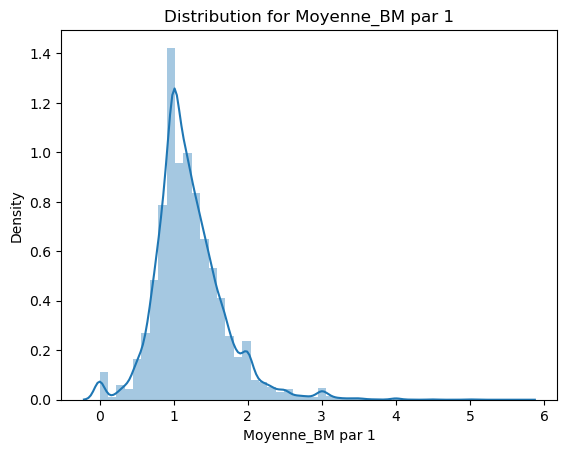

C:\Users\vtgra\AppData\Local\Temp\ipykernel_23956\1251248420.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


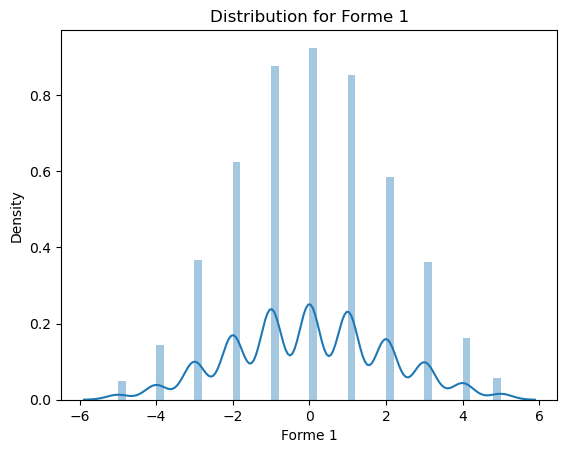

C:\Users\vtgra\AppData\Local\Temp\ipykernel_23956\1251248420.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe_plot[col])


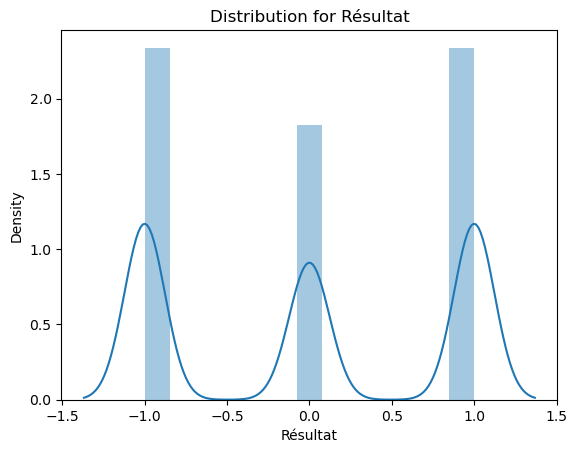

In [45]:
dataframe_plot = dataframe_final[['Moyenne_BM par 1','Forme 1','Résultat']]
for col in dataframe_plot.select_dtypes('number').columns:
    sns.distplot(dataframe_plot[col])
    plt.title(f"Distribution for {col}")
    plt.show()

In [113]:
model=LinearRegression()
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression = dataframe_regression[dataframe_regression['Journée'] > 0]
x1 = dataframe_regression[["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']]
y1 = dataframe_regression[["Buts Equipe 1"]]
model.fit(x1,y1)
y_pred1 =(model.predict(x1))
dataframe_regression ['pred_buts 1'] = y_pred1 
dataframe_regression['residuals 1'] = dataframe_regression['pred_buts 1'] - dataframe_regression['Buts Equipe 1']


x2 = dataframe_regression[["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']]
y2 = dataframe_regression[["Buts Equipe 2"]]
model.fit(x2,y2)
y_pred2 = (model.predict(x2))
dataframe_regression ['pred_buts 2'] = y_pred2
dataframe_regression['residuals 2'] = dataframe_regression['pred_buts 2'] - dataframe_regression['Buts Equipe 2']

conditions = [
    (dataframe_regression['pred_buts 1'] > dataframe_regression['pred_buts 2']),
    (dataframe_regression['pred_buts 1'] < dataframe_regression['pred_buts 2'])
]
valeurs = [1, -1]
dataframe_regression['Résultat prévu'] = 0
dataframe_regression['Résultat prévu'] = np.select(conditions, valeurs)
dataframe_regression['Bon_résultat'] = dataframe_regression['Résultat'] == dataframe_regression['Résultat prévu']
print(dataframe_regression.groupby('Résultat prévu')['Bon_résultat'].value_counts())
print(dataframe_regression['Bon_résultat'].value_counts())




Résultat prévu  Bon_résultat
-1              False           3919
                True            3527
 1              False           3920
                True            3528
Name: Bon_résultat, dtype: int64
False    7839
True     7055
Name: Bon_résultat, dtype: int64


In [118]:
model=LinearRegression()
x1 = dataframe_regression[["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']]
y1 = dataframe_regression[["Résultat"]]
model.fit(x1,y1)
y_pred1 =(model.predict(x1))
dataframe_regression ['pred'] = y_pred1

conditions = [
    (dataframe_regression['pred'] > 0.01),
    (dataframe_regression['pred'] < -0.01)
]
valeurs = [1, -1]
dataframe_regression['pred_résultat'] = 0
dataframe_regression['pred_résultat'] = np.select(conditions, valeurs)

dataframe_regression['Bon résultat'] = dataframe_regression['Résultat'] == dataframe_regression['pred_résultat']
print(dataframe_regression.groupby('pred_résultat')['Bon résultat'].value_counts())
print(dataframe_regression['Bon résultat'].value_counts())

pred_résultat  Bon résultat
-1             False           3777
               True            3446
 0             False            312
               True             136
 1             False           3777
               True            3446
Name: Bon résultat, dtype: int64
False    7866
True     7028
Name: Bon résultat, dtype: int64


In [119]:
dataframe_regression['Test'] = (dataframe_regression['Résultat'] == dataframe_regression['pred_résultat']) | (dataframe_regression['Résultat'] == dataframe_regression['Résultat prévu'])
print(dataframe_regression.groupby('Résultat')['Test'].value_counts())
print(dataframe_regression['Test'].value_counts())

dataframe_regression.to_excel('dataframe_regression.xlsx', index=False)




Résultat  Test 
-1        True     3555
          False    1800
 0        False    4048
          True      136
 1        True     3556
          False    1799
Name: Test, dtype: int64
False    7647
True     7247
Name: Test, dtype: int64


In [120]:
X_train = dataframe_regression[["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']][~(dataframe_regression['Saison'] == '2022-2023')]
Y_train = dataframe_regression["Résultat"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Résultat']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'][["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']]

random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
random_forest_model.fit(X_train, Y_train)


y_pred = random_forest_model.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
classification_report_result = classification_report(Y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.4653
Classification Report:
               precision    recall  f1-score   support

          -1       0.47      0.59      0.52       268
           0       0.36      0.09      0.14       184
           1       0.48      0.60      0.53       268

    accuracy                           0.47       720
   macro avg       0.44      0.43      0.40       720
weighted avg       0.44      0.47      0.43       720



In [115]:
X_train = dataframe_regression[["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']][~(dataframe_regression['Saison'] == '2022-2023')]
Y_train = dataframe_regression["Résultat"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Résultat']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'][["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']]


X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)

svm_model.fit(X_train, Y_train)


Y_pred = svm_model.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred)
classification_report_result = classification_report(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.4578
Classification Report:
               precision    recall  f1-score   support

          -1       0.47      0.64      0.54      1034
           0       0.26      0.01      0.01       789
           1       0.45      0.63      0.52      1012

    accuracy                           0.46      2835
   macro avg       0.39      0.42      0.36      2835
weighted avg       0.40      0.46      0.39      2835



In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Charger vos données
X_train = dataframe_regression[["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']][~(dataframe_regression['Saison'] == '2022-2023')]
Y_train = dataframe_regression["Résultat"][~(dataframe_regression['Saison'] == '2022-2023')]
Y_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023']['Résultat']
X_test = dataframe_regression[dataframe_regression['Saison'] == '2022-2023'][["Classement Equipe 1",  "Classement Equipe 2",  "Moyenne_BM par 1", "Moyenne_BM par 1 selon Lieu", "Moyenne_BE par 1", "Moyenne_BE par 1 selon Lieu","Moyenne_BM par 2", "Moyenne_BM par 2 selon Lieu", "Moyenne_BE par 2", "Moyenne_BE par 2 selon Lieu", 'Forme 1', 'Forme 2', 'Historique']]

# Initialiser les modèles de base
base_models = [
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('logistic_regression', LinearRegression())
]

# Initialiser le modèle de stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=RandomForestClassifier())

# Entraîner le modèle de stacking sur l'ensemble d'entraînement
stacking_model.fit(X_train, Y_train)

# Faire des prédictions sur l'ensemble de test
predictions = stacking_model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.45
